In [14]:
from qiskit.quantum_info import Statevector
from numpy import sqrt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram
import c2qa #Bosonic-qiskit
import qiskit
import numpy as np



In [2]:
x = Statevector([1 / np.sqrt(2), 1 / sqrt(2)])
y = Statevector([1+3.0j, -1])
display(y.draw("latex"))
display(x.draw("latex_source"))
display(y.draw("text"))

<IPython.core.display.Latex object>

'\\frac{\\sqrt{2}}{2} |0\\rangle+\\frac{\\sqrt{2}}{2} |1\\rangle'

[ 1.+3.j,-1.+0.j]

In [3]:
X = QuantumRegister(1,"X")
Y = QuantumRegister(1,"Y")
U = ClassicalRegister(1,"U")
V = ClassicalRegister(1, "V")
circuit = QuantumCircuit(X,Y,U,V)

circuit.h(X)
circuit.cx(X,Y[0])
circuit.measure(X,U)
circuit.measure(Y,V)
display(circuit.draw())

┌───┐     ┌─┐   
  X: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
  Y: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
U: 1/═══════════╩══╬═
                0  ║ 
V: 1/══════════════╩═
                   0

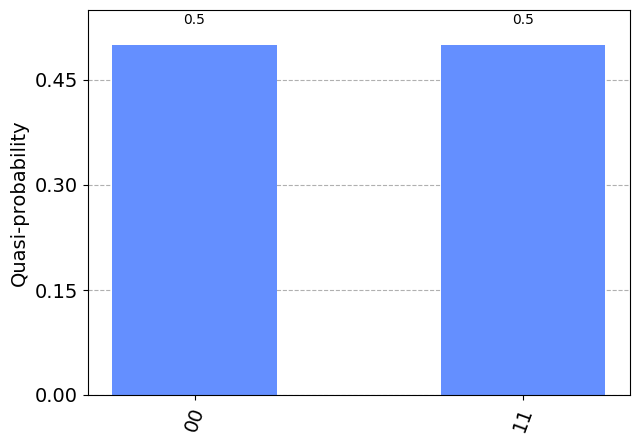

In [4]:
results = Sampler().run(circuit).result()
statistics = results.quasi_dists[0].binary_probabilities()
display(plot_histogram(statistics))

┌───────────┐┌─────────┐   
q140_0: ─────┤0          ├┤0        ├───
             │           ││         │   
q140_1: ─────┤1          ├┤1        ├───
             │           ││  R(π/4) │   
q140_2: ─────┤2 Cd(2,-2) ├┤2        ├───
             │           ││         │   
q140_3: ─────┤3          ├┤3        ├───
        ┌───┐│           │└──┬───┬──┘┌─┐
  q141: ┤ H ├┤4          ├───┤ H ├───┤M├
        └───┘└───────────┘   └───┘   └╥┘
  c5: 1/══════════════════════════════╩═
                                      0

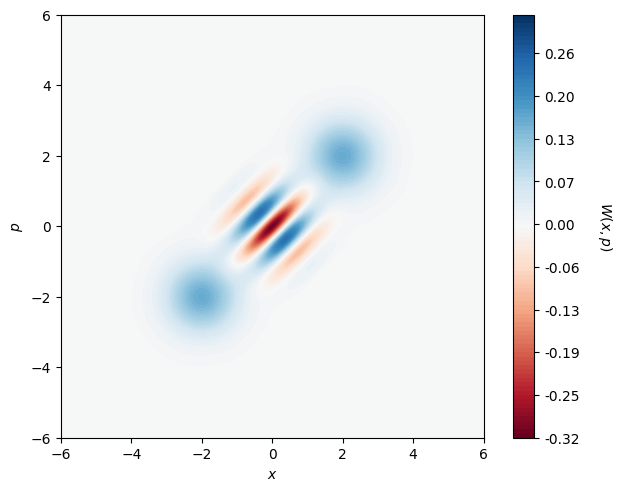

In [26]:
#setup registers
qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode = 4)
qbr = qiskit.QuantumRegister(1)
cr = qiskit.ClassicalRegister(1)

#convenient labeling
qbit = qbr[0]
qumode = qmr[0]

#The circuit is initalized to |0>|0> by default
circuit = c2qa.CVCircuit(qmr, qbr, cr)

#put the qubit into a superposition and then execute a controlled displacement of the cavity
alpha = 2
circuit.h(qbr[0])
circuit.cv_c_d(alpha, qumode, qbit)

#apply a rotation around an angle pi/4
theta = np.pi/4
circuit.cv_r(theta, qumode)

#measure qubit in x basis to collapse into even or odd cat state
circuit.measure_x(qbr, cr)

#simulate and plot
display(circuit.draw())
state, _, _ = c2qa.util.simulate(circuit)
c2qa.wigner.plot_wigner(circuit, state)
#the resulting plot is a cat state that is rotated 45 degrees

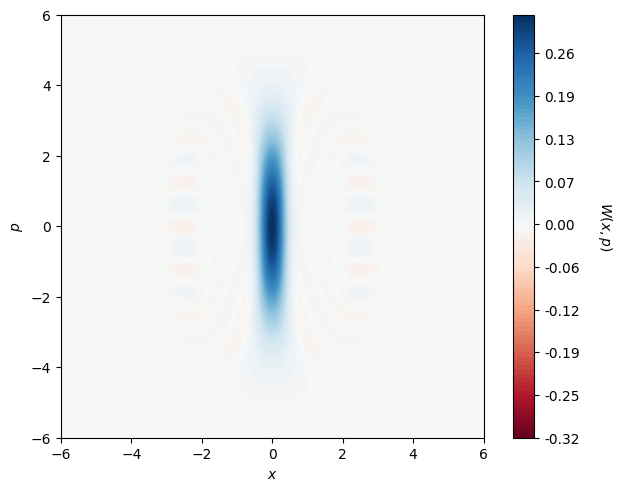

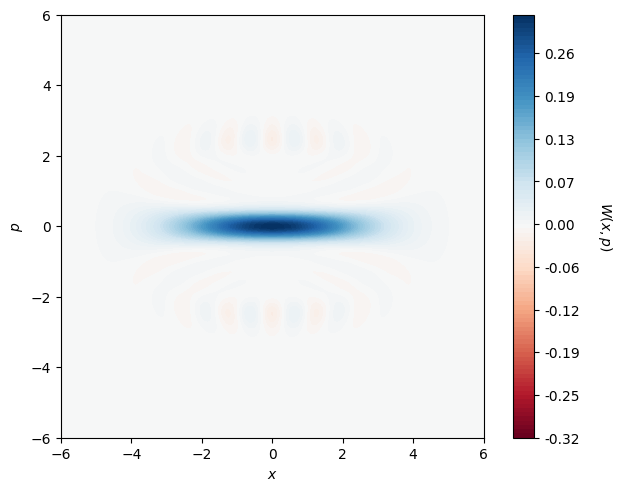

In [27]:
circuit.clear()
s = 1
circuit.cv_initialize(0, qmr[0])
circuit.cv_sq(s, qmr[0])


state, _, _ = c2qa.util.simulate(circuit)
#the resulting plot is a coherent state which is squeezed in the position quadrature
c2qa.wigner.plot_wigner(circuit, state)
circuit.data.pop(1)

#plot a momentum-squeezed state for comparison
circuit.cv_sq(-s, qmr[0])
state, _, _ = c2qa.util.simulate(circuit)
c2qa.wigner.plot_wigner(circuit, state)

In [7]:
import c2qa
import numpy as np
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister, visualization, AncillaRegister
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.quantum_info import state_fidelity, Statevector
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from math import pi, ceil
from scipy.optimize import curve_fit


## Demonstration of photon parity measurement circuit
# Create new circuit with 1 qumode, 1 ancilla qubit, and 1 classical register for anc readout.
num_qumodes = 1
num_qubits_per_qumode = 3
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
anc = AncillaRegister(1)
cr = ClassicalRegister(1)
circ = c2qa.CVCircuit(qmr, anc, cr)

circ.initialize([1, 0], anc[0]) # Initialize ancilla qubit in |0> state

# Initialize qumode in either odd parity or even parity Fock state
#circ.cv_initialize(2, qmr) # |2> Fock state
circ.cv_initialize(3, qmr) # |3> Fock state

# Apply hadamard on ancilla qubit
circ.h(anc[0])

# Apply controlled phase space rotation gate on qumode
circ.cv_c_r(pi/2, qmr[0], anc[0])

# Apply unconditional phase space rotation gate to correct global phase
circ.cv_r(-pi/2, qmr[0])

# Apply hadamard on ancilla qubit again, and measure the ancilla qubit.
circ.h(anc[0])
circ.cv_measure(anc, cr)

_, _, counts = c2qa.util.simulate(circ)

# Measurement will return 0 for even parity and 1 for odd parity
print(counts)

{'1': 1024}


In [8]:
circuit.clear()

In [9]:
#initialize circuit
osc = c2qa.QumodeRegister(1,3,'qumode')
qbit = AncillaRegister(1, 'qubit')
cl = ClassicalRegister(1,'classical')
circ = c2qa.CVCircuit(osc,qbit,cl)

In [10]:
#initialize oscillator and ancillary qubit
circ.initialize([1, 0], qbit[0]) #initialize to |0>
circ.cv_initialize(2, osc) # |3> Fock state

In [11]:
#first Hadamard on the qbit
circ.h(qbit[0])
# Conditional phase space rotation gate
circ.cv_c_r(pi/2, osc[0], qbit[0])
# Non-conditional phase space rotation gate to correct global phase
circ.cv_r(-pi/2, osc[0])
# Hadamard on the qubit again, then measure
circ.h(qbit[0])
circ.cv_measure(qbit, cl)
_,_, counts = c2qa.util.simulate(circ)
print(counts)

{'0': 1024}


In [12]:
display(circ.draw())

┌──────────────────────────────┐     ┌──────────┐┌──────────┐   
   qumode_0: ┤0                             ├─────┤0         ├┤0         ├───
             │                              │     │          ││          │   
   qumode_1: ┤1 Initialize(0,0,1,0,0,0,0,0) ├─────┤1         ├┤1 R(-π/2) ├───
             │                              │     │  Cr(π/2) ││          │   
   qumode_2: ┤2                             ├─────┤2         ├┤2         ├───
             └─────┬─────────────────┬──────┘┌───┐│          │└──┬───┬───┘┌─┐
      qubit: ──────┤ Initialize(1,0) ├───────┤ H ├┤3         ├───┤ H ├────┤M├
                   └─────────────────┘       └───┘└──────────┘   └───┘    └╥┘
classical: 1/══════════════════════════════════════════════════════════════╩═
                                                                           0

In [ ]:
#initialize circuit for rotating a squeezed state
osc = c2qa.QumodeRegister(1,3,'qumode')
qbit = AncillaRegister(1, 'qubit')
cl = ClassicalRegister(1,'classical')
circ = c2qa.CVCircuit(osc,qbit,cl)